## GEE

In [14]:
import ee
import geemap
ee.Initialize()

In [15]:
xmin,ymin,xmax,ymax = [-75.249597, -10.770447, -74.966013, -10.503883]
pol = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])

uriBase = 'gs://rgee_dev/COG/'
collection = ee.ImageCollection(ee.List([
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F7000_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6960_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6990_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6980_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7000_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6990_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26505_FBS_F6950_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7010_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F7020_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6980_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_24988_FBD_F7010_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26082_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26257_FBS_F6970_RT1.cog.tif'),
    ee.Image.loadGeoTIFF(uriBase + 'AP_26257_FBS_F6960_RT1.cog.tif')
]))

mosaic = collection.mosaic()
dem = mosaic.clip(pol).select("B0").toFloat().rename("B14").reproject('EPSG:4326', None, 12.5)
slope = ee.Terrain.slope(dem).select("slope").toFloat().rename("B13")

In [47]:
CLOUD_FILTER = 20
START_DATE = '2020-01-01'
END_DATE = '2020-12-31'
BUFFER = 50
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1

def add_cloud_bands(img):
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    not_water = img.select('SCL').neq(6)
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    img_cloud = add_cloud_bands(img)
    img_cloud_shadow = add_shadow_bands(img_cloud)
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def get_s2_sr_cld_col(aoi, start_date, end_date):
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def apply_cld_shdw_mask(img):
    not_cld_shdw = img.select('cloudmask').Not()
    return img.select('B.*').updateMask(not_cld_shdw)

s2_sr_cld_col = get_s2_sr_cld_col(pol, START_DATE, END_DATE)
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())
d_s2 = s2_sr_median.clip(pol).select("B2","B3","B4","B8")

b2 = d_s2.select("B2").toFloat()#.multiply(0.0001)
b3 = d_s2.select("B3").toFloat()#.multiply(0.0001)
b4 = d_s2.select("B4").toFloat()#.multiply(0.0001)
b8 = d_s2.select("B8").toFloat()#.multiply(0.0001)

# dataset = b1.addBands(b2).addBands(b3).addBands(b4).addBands(b5).addBands(b6).addBands(b7).addBands(b8).addBands(b9).addBands(b10).addBands(b11).addBands(b12).addBands(slope).addBands(dem)
dataset_s2 = b2.addBands(b3).addBands(b4).addBands(b8)
dataset_ap = slope.addBands(dem)

In [48]:
# Map = geemap.Map()
# Map.centerObject(pol, 12)
# Map.addLayer(dataset.select("B13"), {}, 'slope')
# Map.addLayer(dataset.select("B14"), {}, 'dem')

In [49]:
outputBucket = 'rgee_dev'
imageFilePrefix = 'tesis4/ld_2020'
imageTask = ee.batch.Export.image.toCloudStorage(
  image=dataset_s2,
  description='Image Export',
  fileNamePrefix=imageFilePrefix,
  bucket=outputBucket,
  scale=10,
  fileFormat='GeoTIFF',
  region=pol.getInfo()['coordinates'],
  maxPixels=2e8
)
imageTask.start()

# outputBucket = 'rgee_dev'
# imageFilePrefix = 'tesis4/ld_ap_2'
# imageTask = ee.batch.Export.image.toCloudStorage(
#   image=dataset_ap,
#   description='Image Export',
#   fileNamePrefix=imageFilePrefix,
#   bucket=outputBucket,
#   scale=12.5,
#   fileFormat='GeoTIFF',
#   region=pol.getInfo()['coordinates'],
#   maxPixels=2e8
# )
# imageTask.start()

In [50]:
import time
while imageTask.active():
  print('Polling for task (id: {}).'.format(imageTask.id))
  time.sleep(5) # Demora aprox 4:22 min

Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id: ZRNZGTAWPMLJXLVQVS6IG6GM).
Polling for task (id

In [51]:
import rasterio
import numpy as np
from google.cloud import storage
import scipy.ndimage

storage_client = storage.Client()
bucket = storage_client.bucket('rgee_dev')
blob = bucket.blob('tesis4/ld_2020.tif')
blob.download_to_filename('/tmp/ld_2020.tif') # Demora en 20 seg aprox

/home/ryali93/.local/share/r-miniconda/envs/l4s/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/ryali93/.local/share/r-miniconda/envs/l4s/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [52]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

def resamplear(hasta_path, desde_path):
    with rasterio.open(hasta_path) as hasta, rasterio.open(desde_path) as desde:
        # Checar si los sistemas de coordenadas son iguales
        if hasta.crs != desde.crs:
            transform, width, height = calculate_default_transform(
                hasta.crs, desde.crs, hasta.width, hasta.height, *hasta.bounds)
            kwargs = hasta.meta.copy()
            kwargs.update({
                'crs': desde.crs,
                'transform': transform,
                'width': width,
                'height': height
            })
            hasta_resam = rasterio.open('/tmp/hasta_resam.tif', 'w', **kwargs)
            for i in range(1, hasta.count + 1):
                reproject(
                    source=rasterio.band(hasta, i),
                    destination=rasterio.band(hasta_resam, i),
                    src_transform=hasta.transform,
                    src_crs=hasta.crs,
                    dst_transform=transform,
                    dst_crs=desde.crs,
                    resampling=Resampling.nearest)
        else:
            hasta_resam = hasta

        # Checar si las extensiones son iguales
        if hasta_resam.bounds != desde.bounds:
            data = hasta_resam.read(
                out_shape=(hasta_resam.count, desde.height, desde.width),
                resampling=Resampling.nearest)
            transform = desde.transform
        else:
            data = hasta_resam.read()
            transform = hasta_resam.transform

        kwargs = desde.meta.copy()
        kwargs.update({
            'height': desde.height,
            'width': desde.width,
            'transform': transform
        })
        return data

In [53]:
set_dir = "/home/ryali93/Desktop/l4s/test_upload/"
ap_path = set_dir + 'ld_ap.tif'
s2_path = set_dir + 'ld_2020.tif'
d_s2 = rasterio.open(s2_path).read()

ap_resamp = resamplear(ap_path, s2_path)
ap_resamp = np.moveaxis(ap_resamp, 0, -1)
ap_resamp = ap_resamp[:,:,:2]
ap_resamp = np.moveaxis(ap_resamp, -1, 0)
data = np.concatenate((d_s2, ap_resamp), axis=0)

In [54]:
def rellenar_nan(parche):
    for i in range(parche.shape[0]):
        banda = parche[i, :, :]
        mask_nan = np.isnan(banda)
        distancias, indices = scipy.ndimage.distance_transform_edt(mask_nan, return_indices=True)
        banda_copia = banda.copy()
        banda[mask_nan] = banda_copia[indices[0, mask_nan], indices[1, mask_nan]]
        parche[i, :, :] = banda
    return parche

def cortar_en_parches(image_data, size=128):
    n_bandas, width, height = image_data.shape
    n_parches_x = width // size
    n_parches_y = height // size
    parches = []
    for i in range(n_parches_x):
        for j in range(n_parches_y):
            parche = image_data[:, i*size:(i+1)*size, j*size:(j+1)*size]
            parche_rellenado = rellenar_nan(parche)
            parches.append(parche_rellenado)
    return parches

parches = cortar_en_parches(data)

In [55]:
from dataset import DatasetLandslideEval
from model import LandslideModel
import torch

def get_model_pl(model_path):
    model = LandslideModel()
    return  model.load_from_checkpoint(checkpoint_path=model_path)

In [56]:
model_path = r'../models/unet_resnet34_6b_full.ckpt'
model = get_model_pl(model_path)
dataset_eval = DatasetLandslideEval(parches)

In [57]:
loader_1 = torch.utils.data.DataLoader(dataset_eval, batch_size=16)

In [58]:
# 2. Iterar sobre el DataLoader y hacer predicciones
model.eval()  # Poner el modelo en modo evaluación
all_predictions_1 = []

with torch.no_grad():
    for images in loader_1:  # Aquí, estamos desempaquetando las imágenes y las máscaras, pero solo usamos las imágenes
        predictions = model(images)
        # normalize predictions to 0 and 1
        # predictions = torch.sigmoid(predictions)
        # convert to numpy array
        predictions = predictions.cpu().numpy()
        all_predictions_1.append(predictions)

In [59]:
all_predictions_array_1 = np.concatenate(all_predictions_1, axis=0)

In [60]:
import numpy as np

def reconstruir_mascara(parches, size, original_shape):
    _, height, width = original_shape
    mascara_reconstruida = np.zeros(original_shape, dtype=parches[0].dtype)
    n_parches_x = -(-width // size)
    n_parches_y = -(-height // size)
    contador = 0
    for j in range(n_parches_x):
        for i in range(n_parches_y):
            if contador >= len(parches):
                print("Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.")
                break
            parche = parches[contador]
            if parche.ndim == 4: parche = parche[0, 0]
            elif parche.ndim == 3: parche = parche[0]
            espacio_restante_x = min(size, width - i * size)
            espacio_restante_y = min(size, height - j * size)
            parche_ajustado = parche[:espacio_restante_y, :espacio_restante_x]
            mascara_reconstruida[0, j*size:j*size + espacio_restante_y, i*size:i*size + espacio_restante_x] = parche_ajustado
            contador += 1
    return mascara_reconstruida

parches_aplanados_1 = [parche for batch in all_predictions_1 for parche in batch]
# parches_aplanados_2 = [parche for batch in all_predictions_2 for parche in batch]
size = 128
original_shape = (1, 2969, 3158)
mascara_reconstruida_1 = reconstruir_mascara(parches_aplanados_1, size, original_shape)
# mascara_reconstruida_2 = reconstruir_mascara(parches_aplanados_1, size, original_shape)
print(mascara_reconstruida_1.shape)  # Debería ser (1, 2949, 3104)
# print(mascara_reconstruida_2.shape)  # Debería ser (1, 2949, 3104)

Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.
Advertencia: No hay suficientes parches para llenar la imagen. Se rellenará con ceros.
(1, 2969, 3158)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/ryali93/.local/share/r-miniconda/envs/l4s/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


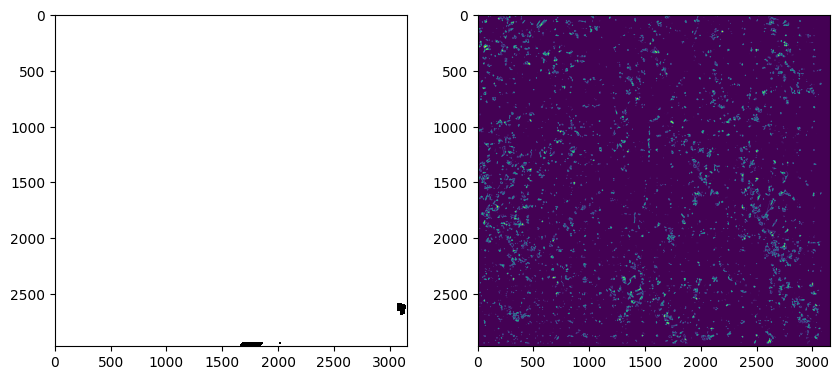

In [69]:
# plot results
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_results(image, prediction):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(prediction) # , cmap=ListedColormap(['black', 'red']), vmin=0, vmax=1
    plt.show()

image = np.moveaxis(data[0:3, :, :], 0, -1)
prediction = (mascara_reconstruida_1[0] < -1) & (mascara_reconstruida_1[0] > -4.5)

plot_results(image, prediction)

In [71]:
# save prediction as geotiff
import rasterio

# Read metadata of first file
with rasterio.open(s2_path) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count=1)

# Read each layer and write it to stack
with rasterio.open('/home/ryali93/Desktop/l4s/test_upload/prediction_2020_n2.tif', 'w', **meta) as dst:
    dst.write(prediction.astype(rasterio.float32), 1)

In [2]:
# REPLACE WITH YOUR USERNAME:
USER_NAME = 'ryali93'
outputAssetID = 'users/' + USER_NAME + '/ld_out'
print('Writing to ' + outputAssetID)

Writing to users/ryali93/ld_out


In [26]:
# Start the upload. It step might take a while.
!earthengine upload image --asset_id={outputAssetID} {outputImageFile} {jsonFile}

Started upload task with ID: LI3VG7KQVKMCQ2H4IXJSR2WN
